# 0. Import packages and extracted python class for classification model

In [373]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 7                                               #
#                                                            #
##############################################################

# Updated by Dave Ebbelaar on 12-01-2023


from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import copy


class ClassificationAlgorithms:

    # Forward selection for classification which selects a pre-defined number of features (max_features)
    # that show the best accuracy. We assume a decision tree learning for this purpose, but
    # this can easily be changed. It return the best features.
    def forward_selection(self, max_features, X_train, y_train):
        # Start with no features.
        ordered_features = []
        ordered_scores = []
        selected_features = []
        ca = ClassificationAlgorithms()
        prev_best_perf = 0

        # Select the appropriate number of features.
        for i in range(0, max_features):
            print(i)

            # Determine the features left to select.
            features_left = list(set(X_train.columns) - set(selected_features))
            best_perf = 0
            best_attribute = ""

            # For all features we can still select...
            for f in features_left:
                temp_selected_features = copy.deepcopy(selected_features)
                temp_selected_features.append(f)

                # Determine the accuracy of a decision tree learner if we were to add
                # the feature.
                (
                    pred_y_train,
                    pred_y_test,
                    prob_training_y,
                    prob_test_y,
                ) = ca.decision_tree(
                    X_train[temp_selected_features],
                    y_train,
                    X_train[temp_selected_features],
                )
                perf = accuracy_score(y_train, pred_y_train)

                # If the performance is better than what we have seen so far (we aim for high accuracy)
                # we set the current feature to the best feature and the same for the best performance.
                if perf > best_perf:
                    best_perf = perf
                    best_feature = f
            # We select the feature with the best performance.
            selected_features.append(best_feature)
            prev_best_perf = best_perf
            ordered_features.append(best_feature)
            ordered_scores.append(best_perf)
        return selected_features, ordered_features, ordered_scores

    # Apply a neural network for classification upon the training data (with the specified composition of
    # hidden layers and number of iterations), and use the created network to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def feedforward_neural_network(
        self,
        train_X,
        train_y,
        test_X,
        hidden_layer_sizes=(100,),
        max_iter=2000,
        activation="logistic",
        alpha=0.0001,
        learning_rate="adaptive",
        gridsearch=True,
        print_model_details=False,
    ):

        if gridsearch:
            tuned_parameters = [
                {
                    "hidden_layer_sizes": [
                        (5,),
                        (10,),
                        (25,),
                        (100,),
                        (
                            100,
                            5,
                        ),
                        (
                            100,
                            10,
                        ),
                    ],
                    "activation": [activation],
                    "learning_rate": [learning_rate],
                    "max_iter": [1000, 2000],
                    "alpha": [alpha],
                }
            ]
            nn = GridSearchCV(
                MLPClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            # Create the model
            nn = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                max_iter=max_iter,
                learning_rate=learning_rate,
                alpha=alpha,
            )

        # Fit the model
        nn.fit(
            train_X,
            train_y.values.ravel(),
        )

        if gridsearch and print_model_details:
            print(nn.best_params_)

        if gridsearch:
            nn = nn.best_estimator_

        # Apply the model
        pred_prob_training_y = nn.predict_proba(train_X)
        pred_prob_test_y = nn.predict_proba(test_X)
        pred_training_y = nn.predict(train_X)
        pred_test_y = nn.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=nn.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=nn.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a support vector machine for classification upon the training data (with the specified value for
    # C, epsilon and the kernel function), and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def support_vector_machine_with_kernel(
        self,
        train_X,
        train_y,
        test_X,
        kernel="rbf",
        C=1,
        gamma=1e-3,
        gridsearch=True,
        print_model_details=False,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [
                {"kernel": ["rbf", "poly"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100]}
            ]
            svm = GridSearchCV(
                SVC(probability=True), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            svm = SVC(
                C=C, kernel=kernel, gamma=gamma, probability=True, cache_size=7000
            )

        # Fit the model
        svm.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(svm.best_params_)

        if gridsearch:
            svm = svm.best_estimator_

        # Apply the model
        pred_prob_training_y = svm.predict_proba(train_X)
        pred_prob_test_y = svm.predict_proba(test_X)
        pred_training_y = svm.predict(train_X)
        pred_test_y = svm.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=svm.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=svm.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a support vector machine for classification upon the training data (with the specified value for
    # C, epsilon and the kernel function), and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def support_vector_machine_without_kernel(
        self,
        train_X,
        train_y,
        test_X,
        C=1,
        tol=1e-3,
        max_iter=1000,
        gridsearch=True,
        print_model_details=False,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [
                {"max_iter": [1000, 2000], "tol": [1e-3, 1e-4], "C": [1, 10, 100]}
            ]
            svm = GridSearchCV(LinearSVC(), tuned_parameters, cv=5, scoring="accuracy")
        else:
            svm = LinearSVC(C=C, tol=tol, max_iter=max_iter)

        # Fit the model
        svm.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(svm.best_params_)

        if gridsearch:
            svm = svm.best_estimator_

        # Apply the model

        distance_training_platt = 1 / (1 + np.exp(svm.decision_function(train_X)))
        pred_prob_training_y = (
            distance_training_platt / distance_training_platt.sum(axis=1)[:, None]
        )
        distance_test_platt = 1 / (1 + np.exp(svm.decision_function(test_X)))
        pred_prob_test_y = (
            distance_test_platt / distance_test_platt.sum(axis=1)[:, None]
        )
        pred_training_y = svm.predict(train_X)
        pred_test_y = svm.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=svm.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=svm.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a nearest neighbor approach for classification upon the training data (with the specified value for
    # k), and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def k_nearest_neighbor(
        self,
        train_X,
        train_y,
        test_X,
        n_neighbors=5,
        gridsearch=True,
        print_model_details=False,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [{"n_neighbors": [1, 2, 5, 10]}]
            knn = GridSearchCV(
                KNeighborsClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)

        # Fit the model
        knn.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(knn.best_params_)

        if gridsearch:
            knn = knn.best_estimator_

        # Apply the model
        pred_prob_training_y = knn.predict_proba(train_X)
        pred_prob_test_y = knn.predict_proba(test_X)
        pred_training_y = knn.predict(train_X)
        pred_test_y = knn.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=knn.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=knn.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a decision tree approach for classification upon the training data (with the specified value for
    # the minimum samples in the leaf, and the export path and files if print_model_details=True)
    # and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def decision_tree(
        self,
        train_X,
        train_y,
        test_X,
        min_samples_leaf=50,
        criterion="gini",
        print_model_details=False,
        export_tree_path="Example_graphs/Chapter7/",
        export_tree_name="tree.dot",
        gridsearch=True,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [
                {
                    "min_samples_leaf": [2, 10, 50, 100, 200],
                    "criterion": ["gini", "entropy"],
                }
            ]
            dtree = GridSearchCV(
                DecisionTreeClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            dtree = DecisionTreeClassifier(
                min_samples_leaf=min_samples_leaf, criterion=criterion
            )

        # Fit the model

        dtree.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(dtree.best_params_)

        if gridsearch:
            dtree = dtree.best_estimator_

        # Apply the model
        pred_prob_training_y = dtree.predict_proba(train_X)
        pred_prob_test_y = dtree.predict_proba(test_X)
        pred_training_y = dtree.predict(train_X)
        pred_test_y = dtree.predict(test_X)
        frame_prob_training_y = pd.DataFrame(
            pred_prob_training_y, columns=dtree.classes_
        )
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=dtree.classes_)

        if print_model_details:
            ordered_indices = [
                i[0]
                for i in sorted(
                    enumerate(dtree.feature_importances_),
                    key=lambda x: x[1],
                    reverse=True,
                )
            ]
            print("Feature importance decision tree:")
            for i in range(0, len(dtree.feature_importances_)):
                print(
                    train_X.columns[ordered_indices[i]],
                )
                print(
                    " & ",
                )
                print(dtree.feature_importances_[ordered_indices[i]])
            tree.export_graphviz(
                dtree,
                out_file=export_tree_path + export_tree_name,
                feature_names=train_X.columns,
                class_names=dtree.classes_,
            )

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a naive bayes approach for classification upon the training data
    # and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def naive_bayes(self, train_X, train_y, test_X):
        # Create the model
        nb = GaussianNB()

        # Fit the model
        nb.fit(train_X, train_y)

        # Apply the model
        pred_prob_training_y = nb.predict_proba(train_X)
        pred_prob_test_y = nb.predict_proba(test_X)
        pred_training_y = nb.predict(train_X)
        pred_test_y = nb.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=nb.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=nb.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a random forest approach for classification upon the training data (with the specified value for
    # the minimum samples in the leaf, the number of trees, and if we should print some of the details of the
    # model print_model_details=True) and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def random_forest(
        self,
        train_X,
        train_y,
        test_X,
        n_estimators=10,
        min_samples_leaf=5,
        criterion="gini",
        print_model_details=False,
        gridsearch=True,
    ):

        if gridsearch:
            tuned_parameters = [
                {
                    "min_samples_leaf": [2, 10, 50, 100, 200],
                    "n_estimators": [10, 50, 100],
                    "criterion": ["gini", "entropy"],
                }
            ]
            rf = GridSearchCV(
                RandomForestClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                min_samples_leaf=min_samples_leaf,
                criterion=criterion,
            )

        # Fit the model

        rf.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(rf.best_params_)

        if gridsearch:
            rf = rf.best_estimator_

        pred_prob_training_y = rf.predict_proba(train_X)
        pred_prob_test_y = rf.predict_proba(test_X)
        pred_training_y = rf.predict(train_X)
        pred_test_y = rf.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=rf.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=rf.classes_)

        if print_model_details:
            ordered_indices = [
                i[0]
                for i in sorted(
                    enumerate(rf.feature_importances_), key=lambda x: x[1], reverse=True
                )
            ]
            print("Feature importance random forest:")
            for i in range(0, len(rf.feature_importances_)):
                print(
                    train_X.columns[ordered_indices[i]],
                )
                print(
                    " & ",
                )
                print(rf.feature_importances_[ordered_indices[i]])

        return (
            pred_training_y,
            pred_test_y,
            frame_prob_training_y,
            frame_prob_test_y,
        )

# 1. Load Dataset: 

In [374]:
import pandas as pd

In [375]:
df = pd.read_pickle("../../data/interim/df_81_features.pkl")

In [376]:
df

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,subject_id,trial,age,...,acc_z_entropy,gyro_x_fft,gyro_x_psd,gyro_x_entropy,gyro_y_fft,gyro_y_psd,gyro_y_entropy,gyro_z_fft,gyro_z_psd,gyro_z_entropy
timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:38:39.700,-0.068994,-6.987095,5.288118,1.340131,0.254273,0.553948,BSC,1.0,1.0,32.0,...,0.552713,2.237175,0.000722,0.920616,0.363307,0.000888,1.282563,0.614725,0.000267,1.354238
1970-01-01 00:38:40.200,-0.470804,-1.801783,8.929937,1.701367,0.193919,0.328752,BSC,1.0,1.0,32.0,...,0.697146,1.886452,0.000581,0.905243,0.727568,0.000668,1.175494,1.138423,0.000603,1.415926
1970-01-01 00:38:40.700,-9.901018,13.441229,7.822155,-0.351828,0.343581,-0.851439,BSC,1.0,1.0,32.0,...,1.074713,3.329770,0.005098,1.203505,1.706857,0.000565,0.936669,3.093796,0.002285,0.577150
1970-01-01 00:38:41.200,-5.150726,6.613287,3.195224,-0.107008,-1.118601,-0.638797,BSC,1.0,1.0,32.0,...,1.461785,9.083104,0.043227,1.271543,2.602335,0.005232,1.358140,3.267480,0.006812,0.745639
1970-01-01 00:38:41.700,-4.931030,5.574285,6.261700,-0.019441,0.012431,0.115133,BSC,1.0,1.0,32.0,...,1.176317,1.104385,0.000710,1.366146,3.538939,0.009700,1.667364,0.830726,0.003255,1.440714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 04:49:53.200,0.586223,5.443400,1.029336,-0.737727,1.443459,1.335214,WAL,67.0,1.0,23.0,...,1.343248,7.967362,0.019501,0.917517,3.978832,0.003662,1.133685,9.439387,0.030438,0.913799
1970-01-01 04:49:53.700,2.286937,11.130139,-1.195925,1.260658,-0.457721,-0.981431,WAL,67.0,1.0,23.0,...,1.502760,7.253110,0.017147,0.899968,6.142548,0.022069,1.258938,8.046604,0.023517,0.994088
1970-01-01 04:49:54.200,-5.076769,14.152212,2.039380,-2.541764,-1.378478,2.412521,WAL,67.0,1.0,23.0,...,1.377740,5.479225,0.007237,1.008082,3.459003,0.006143,1.726653,5.018624,0.007999,1.087638


# 2. Data Splitting

In [377]:
# Drop subject ID and trail
df_train = df.drop(["subject_id", "trial"], axis = 1)

In [378]:
X = df_train.drop("label", axis =1)
y = df_train["label"]

In [408]:
X['acc_x_mean'].head()

timestamp
1970-01-01 00:38:39.700    0.855605
1970-01-01 00:38:40.200    0.162012
1970-01-01 00:38:40.700   -1.726724
1970-01-01 00:38:41.200   -4.307600
1970-01-01 00:38:41.700   -5.465859
Name: acc_x_mean, dtype: float64

In [380]:
y

timestamp
1970-01-01 00:38:39.700    BSC
1970-01-01 00:38:40.200    BSC
1970-01-01 00:38:40.700    BSC
1970-01-01 00:38:41.200    BSC
1970-01-01 00:38:41.700    BSC
                          ... 
1970-01-01 04:49:53.200    WAL
1970-01-01 04:49:53.700    WAL
1970-01-01 04:49:54.200    WAL
1970-01-01 04:49:54.700    WAL
1970-01-01 04:49:55.200    WAL
Name: label, Length: 167662, dtype: object

In [381]:
from sklearn.model_selection import train_test_split

In [382]:
# Split with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [383]:
y_train.value_counts()

label
STD    37368
WAL    36817
SIT     8956
JOG     8653
JUM     8347
LYI     7581
STU     4910
STN     4504
CSO     2335
CSI     2198
SCH     1190
BSC      762
SDL      644
FKL      609
FOL      536
CHU      336
Name: count, dtype: int64

In [384]:
y_test.value_counts()

label
STD    12456
WAL    12273
SIT     2985
JOG     2884
JUM     2783
LYI     2527
STU     1637
STN     1501
CSO      779
CSI      733
SCH      397
BSC      254
SDL      214
FKL      203
FOL      178
CHU      112
Name: count, dtype: int64

In [385]:
df_train.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'label', 'age',
       'height', 'weight', 'gender', 'acc_mag', 'gyro_mag', 'acc_x_mean',
       'acc_x_std', 'acc_x_skew', 'acc_x_kurtosis', 'acc_x_jerk', 'acc_x_min',
       'acc_x_max', 'acc_x_minmax_diff', 'acc_y_mean', 'acc_y_std',
       'acc_y_skew', 'acc_y_kurtosis', 'acc_y_jerk', 'acc_y_min', 'acc_y_max',
       'acc_y_minmax_diff', 'acc_z_mean', 'acc_z_std', 'acc_z_skew',
       'acc_z_kurtosis', 'acc_z_jerk', 'acc_z_min', 'acc_z_max',
       'acc_z_minmax_diff', 'gyro_x_mean', 'gyro_x_std', 'gyro_x_skew',
       'gyro_x_kurtosis', 'gyro_x_jerk', 'gyro_x_min', 'gyro_x_max',
       'gyro_x_minmax_diff', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_skew',
       'gyro_y_kurtosis', 'gyro_y_jerk', 'gyro_y_min', 'gyro_y_max',
       'gyro_y_minmax_diff', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_skew',
       'gyro_z_kurtosis', 'gyro_z_jerk', 'gyro_z_min', 'gyro_z_max',
       'gyro_z_minmax_diff', 'acc_x_fft', 'acc_x_psd', 'acc_x

# 3. Modelling

In [386]:
# Split features

basic_features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'acc_mag', 'gyro_mag']
subject_features = ['age', 'height', 'weight']
frequency_features = [f for f in df_train.columns if any(suffix in f for suffix in ['psd', 'entropy', 'fft'])]
time_features = [f for f in df_train.columns if any(suffix in f for suffix in ['mean', 'std', 'skew', 'kurtosis','jerk','min','max','minmax_diff'])]


In [387]:
X.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'age',
       'height', 'weight', 'gender', 'acc_mag', 'gyro_mag', 'acc_x_mean',
       'acc_x_std', 'acc_x_skew', 'acc_x_kurtosis', 'acc_x_jerk', 'acc_x_min',
       'acc_x_max', 'acc_x_minmax_diff', 'acc_y_mean', 'acc_y_std',
       'acc_y_skew', 'acc_y_kurtosis', 'acc_y_jerk', 'acc_y_min', 'acc_y_max',
       'acc_y_minmax_diff', 'acc_z_mean', 'acc_z_std', 'acc_z_skew',
       'acc_z_kurtosis', 'acc_z_jerk', 'acc_z_min', 'acc_z_max',
       'acc_z_minmax_diff', 'gyro_x_mean', 'gyro_x_std', 'gyro_x_skew',
       'gyro_x_kurtosis', 'gyro_x_jerk', 'gyro_x_min', 'gyro_x_max',
       'gyro_x_minmax_diff', 'gyro_y_mean', 'gyro_y_std', 'gyro_y_skew',
       'gyro_y_kurtosis', 'gyro_y_jerk', 'gyro_y_min', 'gyro_y_max',
       'gyro_y_minmax_diff', 'gyro_z_mean', 'gyro_z_std', 'gyro_z_skew',
       'gyro_z_kurtosis', 'gyro_z_jerk', 'gyro_z_min', 'gyro_z_max',
       'gyro_z_minmax_diff', 'acc_x_fft', 'acc_x_psd', 'acc_x_entropy'

In [388]:
feature_set_1 = list(set(basic_features))
feature_set_2 = list(set(basic_features + subject_features))
feature_set_3 = list(set(feature_set_2 + frequency_features))
feature_set_4 = list(set(feature_set_2 + time_features))
feature_set_5 = list(set(feature_set_3 + time_features))

In [389]:
feature_set_4

['acc_x_skew',
 'acc_x_kurtosis',
 'gyro_z_minmax_diff',
 'acc_x_min',
 'acc_z_jerk',
 'gyro_z_jerk',
 'acc_y_kurtosis',
 'acc_y_std',
 'gyro_y_std',
 'acc_x_mean',
 'acc_x_std',
 'acc_z_kurtosis',
 'acc_y_jerk',
 'gyro_x_jerk',
 'acc_y_skew',
 'gyro_y_jerk',
 'gyro_z_skew',
 'gyro_z_min',
 'gyro_y_minmax_diff',
 'gyro_y_min',
 'acc_y_min',
 'acc_z_max',
 'acc_x_max',
 'acc_z_min',
 'gyro_x_skew',
 'acc_z_std',
 'gyro_x_kurtosis',
 'gyro_x',
 'gyro_z_kurtosis',
 'weight',
 'gyro_x_min',
 'acc_z',
 'gyro_y_mean',
 'gyro_mag',
 'acc_y',
 'acc_y_mean',
 'gyro_y_max',
 'acc_y_max',
 'acc_mag',
 'acc_y_minmax_diff',
 'gyro_x_minmax_diff',
 'acc_z_mean',
 'gyro_z_mean',
 'gyro_z',
 'gyro_x_max',
 'gyro_y',
 'gyro_y_skew',
 'gyro_x_std',
 'gyro_y_kurtosis',
 'acc_x',
 'acc_x_jerk',
 'gyro_z_std',
 'age',
 'height',
 'gyro_z_max',
 'gyro_x_mean',
 'acc_x_minmax_diff',
 'acc_z_minmax_diff',
 'acc_z_skew']

In [390]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    feature_set_5
]

In [391]:
feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Only timewindow",
    "ALL Features"
]

In [392]:
# Call the class defined abovce as learner

learner = ClassificationAlgorithms()

In [393]:

iterations = 1
score_df = pd.DataFrame()



for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=False
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=False
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=False
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


In [397]:
import matplotlib.pyplot as plt
import seaborn as sns

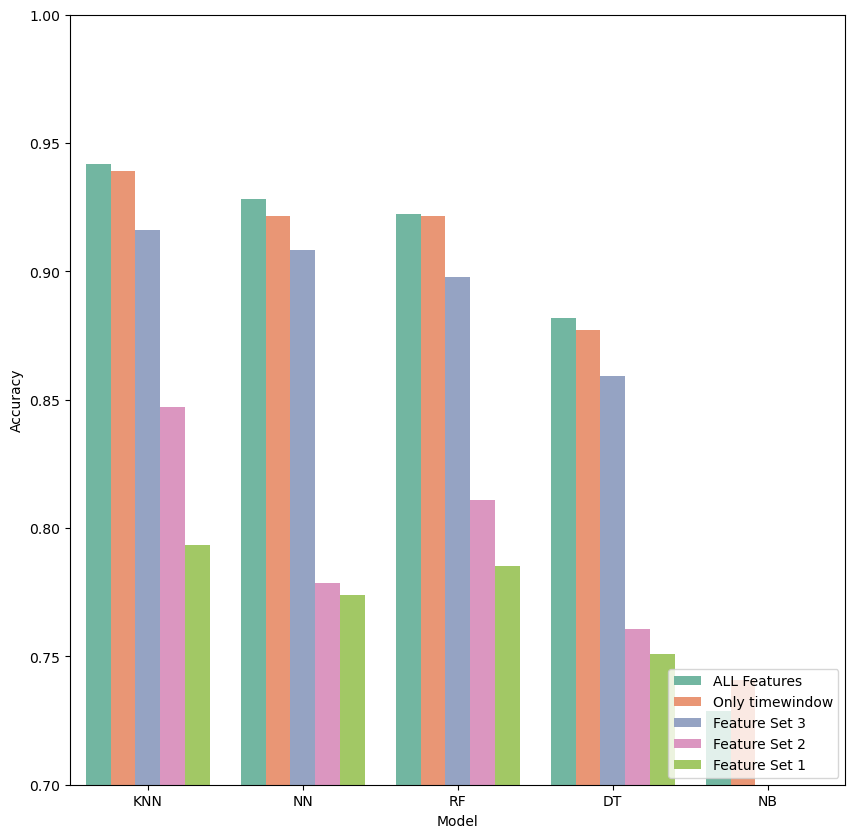

In [398]:
score_df = score_df.sort_values(by="accuracy", ascending=False)  # Ensure sorting is applied

plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df, palette="Set2")  # Fixed typo
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.show()

In [396]:
len(feature_set_5)

77